In [3]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
from sklearn import linear_model
import seaborn as sns
import warnings
from jupyterthemes import jtplot

In [4]:
%matplotlib inline
jtplot.style()
sns.set_context("poster")
warnings.filterwarnings("ignore")

In [5]:
folder_to_process = "shadow_1"

In [6]:
# this file is used to process the raw output of recording training data from the simulator
# and prepare it for uploading to the AWS GPU


print("Processing ", folder_to_process)


def extract_data(folder):
    S = [] #image sequence id
    P = [] #shadow predictions 
    X = [] #images
    XX = [] #senor data (aka speed in this case)
    y = [] #actual steering angles (throttle in the future)
    
    shadow_predictions = {}
    with open('data/{}/_predictions.csv'.format(folder_to_process)) as f:
        reader = csv.reader(f)
        for line in reader:
            image_seq_id = int(line[0])
            prediction = float(line[1])/45.0
            shadow_predictions[image_seq_id] = prediction

    with open('data/{}/_data.csv'.format(folder_to_process)) as f:
        reader = csv.reader(f)
        print(''.join(next(reader)))
        for line in reader:
            line = ''.join(line).split('|')
            image_seq_id= int(line[0])
            
            # only process frames we ended up predicting on
            # no sense training on dropped frames
            if image_seq_id not in shadow_predictions:
                continue
                
            img = imread('data/{}/{}.jpg'.format(folder_to_process, image_seq_id))
            
            S.append(image_seq_id)
            P.append(shadow_predictions[image_seq_id])
            X.append(img)
            #index 8 - throttle is -100 to 100
            #index 7 - rpm is 5000ish max
            XX.append([float(line[7])/5000, float(line[8])/100]) 
            y.append([float(line[5])/45.0]) # steering is -45 to 45

    return np.array(S), np.array(P), np.array(X), np.array(XX), np.array(y)


S_train, P_train, X_train, XX_train, y_train = extract_data(folder_to_process)

#clean up the beginning and the end of the clip
data_frames_to_drop = [(0,200), (-300, -1)]
clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

S_train = S_train[clean_indicies.astype(np.bool)]
P_train = P_train[clean_indicies.astype(np.bool)]
X_train = X_train[clean_indicies.astype(np.bool)]
XX_train = XX_train[clean_indicies.astype(np.bool)]
y_train = y_train[clean_indicies.astype(np.bool)]


print("--done--")

Processing  shadow_1
image_id|ACC|MAG|UFL|GYR|STR|UFR|RPM|THR|PRH|time
--done--


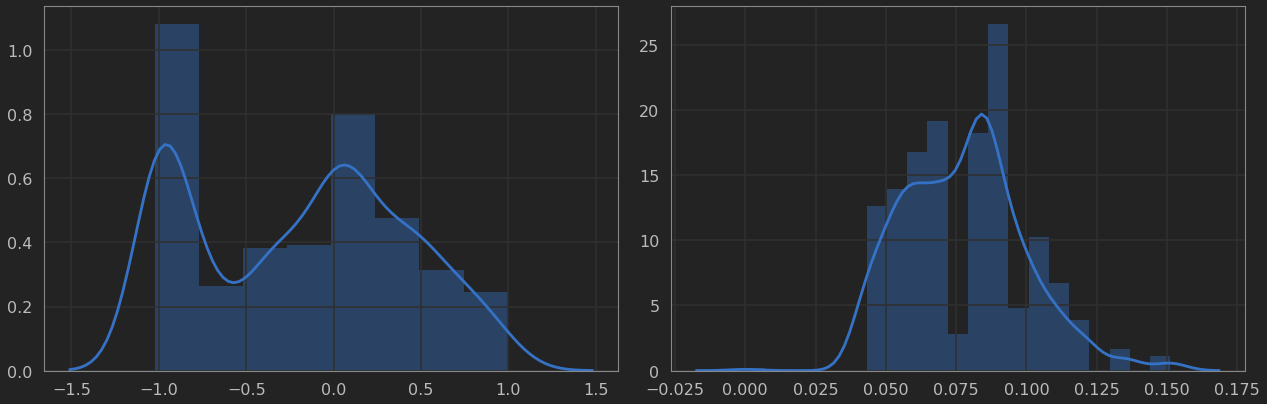

In [6]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.distplot(y_train)
plt.subplot(1,2,2)
sns.distplot(XX_train[:,0])
plt.tight_layout()

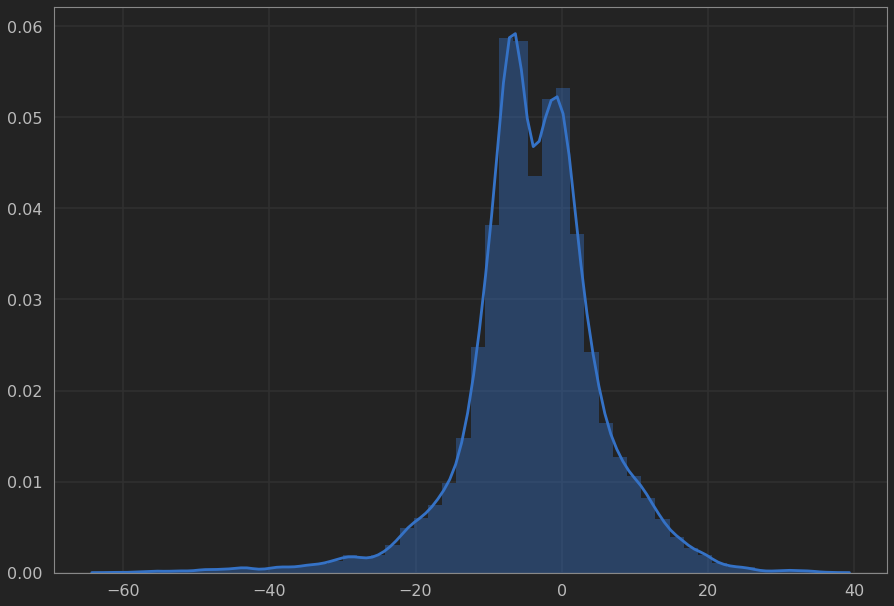

In [7]:
#now to look at how off the predictions are from the actual input
pred_actual = zip(P_train, y_train)

#get the over underssteed in ether direction in total degrees
pred_actual_delta = [((x[1] - x[0]) * (-1 if x[1] >0 else 1) * 45) for x in pred_actual]
sns.distplot(pred_actual_delta)
plt.tight_layout()

In [8]:
frame_id = 19

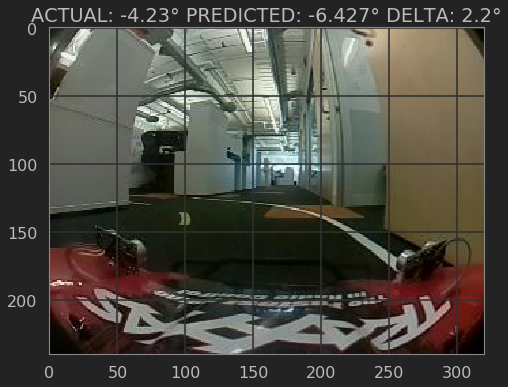

In [9]:
plt.figure(figsize=(10,6))
plt.title("ACTUAL: {}° PREDICTED: {}° DELTA: {}°".format(
    round(y_train[frame_id][0] * 45,3), 
    round(P_train[frame_id]* 45,3), 
    round(pred_actual_delta[frame_id][0],1)))
plt.imshow(X_train[frame_id])
frame_id += 10

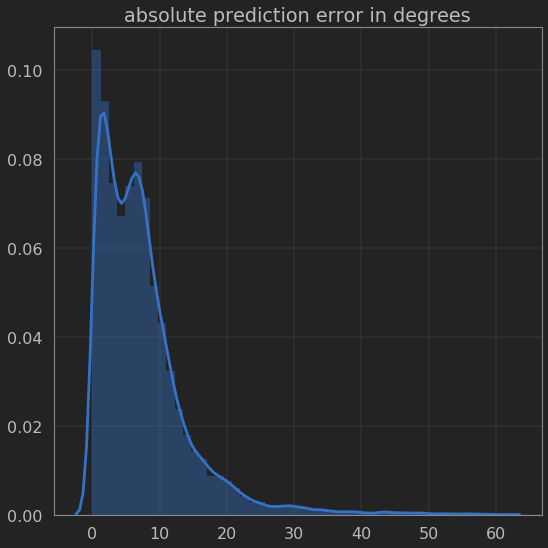

In [11]:
plt.figure(figsize=(8,8))
plt.title("absolute prediction error in degrees")
sns.distplot(np.abs(pred_actual_delta))
plt.tight_layout()

In [12]:
delta_threshold = 8
bad_frames = (np.abs(pred_actual_delta) > delta_threshold).reshape(-1)

In [13]:
#how much data is above the threshold
sum(bad_frames)/len(bad_frames)

0.34866560078711106

In [14]:
xx_train = [] #images
pp_train = [] #predictions
yy_train = [] #actual steering
ss_train = [] #sensors
dd_train = [] #delta
for bad_frame_index, bad in enumerate(bad_frames[:-90]):
# for i, bad in enumerate(bad_frames[:20]):
    if bad:
        frame_start = S_train[bad_frame_index]
        frame_end = frame_start + 90
        working_index = bad_frame_index
#         print("found bad frame at", i, frame_start)
#         print ("starting at", frame_start, "ending at", frame_end)
        steering_angles_actual = [y_train[bad_frame_index]]
        steering_angles_predicted = [P_train[bad_frame_index]]
        for ii in range(3,90, 3):
            next_img_index = frame_start + ii
#             print('-----------------')
#             print ("trying to find:", next_img_index)
            
            #keep track of the last considered index so in case in exact match is not 
            #found, we have both the index greater and smaller than the desired index
            #and we can fit a line
            last_considered_index = working_index
            while S_train[working_index] < next_img_index:
                last_considered_index = working_index
                working_index += 1
                
#             print(last_considered_index, S_train[last_considered_index], 
#                   working_index,  S_train[working_index])
            if S_train[working_index] == next_img_index:
#                 print("FOUND IT")
                steering_angles_actual.append(y_train[working_index])
                steering_angles_predicted.append(P_train[working_index])
            else:
                # fit a linear model between the two points and interpolate the value
                y_1, y_2 = y_train[last_considered_index], y_train[working_index]
                x_1, x_2 = S_train[last_considered_index], S_train[working_index]
                
                regr = linear_model.LinearRegression()
                regr.fit(np.array([x_1, x_2]).reshape(-1, 1), 
                         np.array([y_1, y_2]).reshape(-1, 1))
                y_interpolated = regr.predict(next_img_index)
                steering_angles_actual.append(y_interpolated[0])
    
                #also find what would predicted if this frame is missing
                y_1, y_2 = P_train[last_considered_index], P_train[working_index]
                regr = linear_model.LinearRegression()
                regr.fit(np.array([x_1, x_2]).reshape(-1, 1), 
                         np.array([y_1, y_2]).reshape(-1, 1))
                y_interpolated = regr.predict(next_img_index)
                steering_angles_predicted.append(y_interpolated[0])
        
        
        xx_train.append(X_train[bad_frame_index])
        ss_train.append(XX_train[bad_frame_index])
        yy_train.append(steering_angles_actual)
        pp_train.append(steering_angles_predicted)
        dd_train.append(pred_actual_delta[bad_frame_index])
        
        
yy_train = np.array(yy_train).reshape(-1,30)
xx_train = np.array(xx_train)
ss_train = np.array(ss_train)
dd_train = np.array(dd_train)
pp_train = np.array(pp_train).reshape(-1,30)

In [15]:
def pipeline(image):
    #undistort it
#     undistort = cv2.undistort(image, mtx, dist, None, mtx)
    output = image[100:180,:,:]
    return  output

In [16]:
frame=0
def display_frame(frame_id):
    plt.figure(figsize=(18,6))
    plt.subplot(222)
    plt.title("{} - ACTUAL: {}° PREDICTED: {}° DELTA: {}°".format(
        frame_id,
        round(yy_train[frame_id][0] * 45,3), 
        round(pp_train[frame_id][0]* 45,3), 
        round(dd_train[frame_id][0],1)))
    plt.imshow(xx_train[frame_id])
    
    plt.subplot(224)
    plt.title("Frames to scrub")
    plt.imshow(np.tile(frames_to_remove,(50,1)), cmap="OrRd")
    
    plt.subplot(121)
    plt.plot(yy_train[frame_id] * 45,np.arange(0,90,3), label="actual angle")
    plt.plot(pp_train[frame_id] * 45,np.arange(0,90,3), label="predicted angle")
   
    plt.plot((yy_train[frame_id] - pp_train[frame_id]) * [-1 if x>0 else 1 for x in yy_train[0]] * 45 ,np.arange(0,90,3), label="over/understeer angle")
    plt.ylim((0,90))
    plt.xlim((-45,45)) 
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
#reduce image to the road section and apply any transforms in the pipeline
xx_train = np.array([pipeline(x) for x in xx_train])

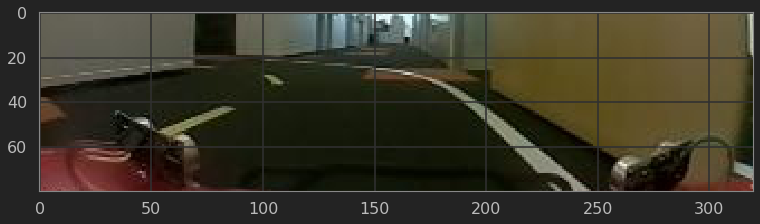

In [18]:
plt.imshow(xx_train[0])

In [20]:
#scrub through thismanually for bad frames.... ouch time consuming
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
from IPython.display import display

total_frames = len(xx_train) - 1
frames_to_remove = np.zeros(len(xx_train))

#frame selection
play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=total_frames,
    interval=800,
    step=1,
    description="Play",
    disabled=False
)
frame_selection_slider = widgets.IntSlider(min=0,max=total_frames,step=1,value=0, 
    continuous_update=False,
    layout=Layout(width="100%"))
frame_selection_text = widgets.Text(layout=Layout(width="100px"))
widgets.jslink((frame_selection_slider, 'value'), (frame_selection_text, 'value'))
widgets.jslink((frame_selection_slider, 'value'), (play, 'value'))

#mark bad frames
mark_bad_range = widgets.IntRangeSlider(
    value=[0, 0],
    min=0,
    max=total_frames,
    step=1,
    description='Bad Frames:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=Layout(width="100%")
)

def on_bad_range_click(btn):
    start, finish = mark_bad_range.value
    frames_to_remove[start:finish] = 1
    output.layout.height = '450px'
    interactive_plot.update()
    
add_bad_frames_btn = widgets.Button(
    description='Add range of bad frames',
    disabled=False,
    button_style='danger',
    tooltip='Click me',
    icon='delete'
)
add_bad_frames_btn.on_click(on_bad_range_click)
interactive_plot = interactive(display_frame, frame_id=frame_selection_slider)
output = interactive_plot.children[-1]
output.layout.height = '450px'

def display_scrubber():
    display(widgets.HBox([play, frame_selection_text,add_bad_frames_btn ]),
            mark_bad_range,interactive_plot )
display_scrubber()

In [21]:
# drop bad frames
clean_indicies = frames_to_remove.astype(np.bool) ^ 1

In [22]:
xx_cleaned = xx_train[clean_indicies.astype(np.bool)]
ss_cleaned = ss_train[clean_indicies.astype(np.bool)]
yy_cleaned = yy_train[clean_indicies.astype(np.bool)]
dd_cleaned = dd_train[clean_indicies.astype(np.bool)]

print(xx_cleaned.shape, ss_cleaned.shape, yy_cleaned.shape)

data = {
    "images": xx_cleaned,
    "sensors": ss_cleaned,
    "steering_throttle": yy_cleaned
}

(5660, 80, 320, 3) (5660, 2) (5660, 30)


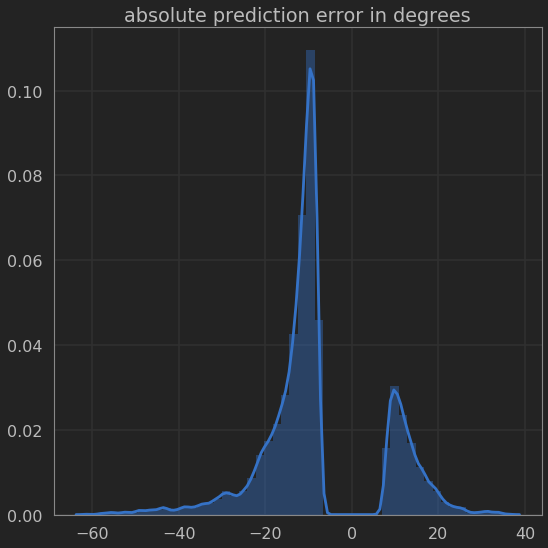

In [23]:
plt.figure(figsize=(8,8))
plt.title("absolute prediction error in degrees")
sns.distplot(dd_cleaned)
plt.tight_layout()

In [24]:
with open('V79_shadow_run_{}.pkl'.format(folder_to_process), 'wb') as f:
    pickle.dump(data, f)